## Imports

In [84]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scanpy as sc
import bottleneck
from scipy import stats
from scipy import io
import gc
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import joypy
import seaborn as sns

from itertools import product
from scipy.cluster import hierarchy

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

from itertools import combinations
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

import networkx as nx
%matplotlib inline

In [85]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [86]:
import sys
sys.path.append('../scripts/')
sys.path.append('/home/bharris/Correlation_Coexpression/scripts/')
sys.path.append('/home/bharris/vshape/scripts/')

In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
from rank import rank
from empirical_fdr import calc_fdr
import load_pearson_networks
from differential_coexpression import calculate_quantile_fdr

## Functions

## Load Dataset Num Results

In [89]:
dataset_num = pd.read_csv(
    '/home/bharris/biccn_paper/data/differential_coexpression/class_differential_coexpression.csv'
)

dataset_num.drop('Unnamed: 0', inplace=True, axis=1)

dataset_num = dataset_num[dataset_num.cell_type == 'GABAergic']

ds_num = dataset_num.groupby(['n_datasets', 'FDR',
                              'level']).mean().reset_index()

ds_num.n_datasets = ds_num.n_datasets.astype(int)


level_dict = {
    'class_label': 'Class Label',
    'subclass_label': 'Subclass Label',
    'joint_cluster_label': 'Cluster Label'
}

cleaned_results=[]
for level in ['class_label','subclass_label','joint_cluster_label']:
    for i in np.arange(2,8):
        temp = ds_num[(ds_num.n_datasets == i)
                  & (ds_num.level == level)].sort_values('FDR')
        temp.Density = np.minimum.accumulate(temp.Density.values[::-1])[::-1]
        temp.drop_duplicates('Density',keep='first',inplace=True)
        temp['level'] = level_dict[level]
        temp['# of Datasets'] = i
        cleaned_results.append(temp)

cleaned_n_ds_res = pd.concat(cleaned_results)

In [90]:
gist_earth = sns.color_palette('gist_earth', 3)

gist_earth[0] = 'k'

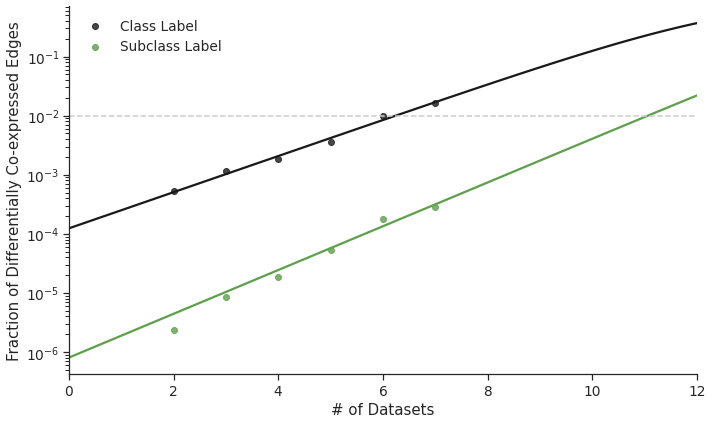

In [93]:
lv = "Class Label"
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=[0, 12])
sns.regplot(data=cleaned_n_ds_res.query('FDR<.01 & level == @lv').groupby(
    ['n_datasets']).max().reset_index(),
            x='# of Datasets',
            y='Density',
            truncate=False,
            logistic=True,
            color=gist_earth[0],
            ax=ax,
            label=lv)
lv = 'Subclass Label'
sns.regplot(data=cleaned_n_ds_res.query('FDR<.01 & level == @lv').groupby(
    ['n_datasets']).max().reset_index(),
            x='# of Datasets',
            y='Density',
            truncate=False,
            logistic=True,
            color=gist_earth[1],
            ax=ax,
            label=lv)
ax.set(ylabel='Fraction of Differentially Co-expressed Edges',
       yscale='log')
ax.axhline(1e-2, ls='--', c='.8')
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/resub/diff_coexpression.pdf',
            transparent=True)

In [94]:
dce_nw = pd.read_hdf(
    '/home/bharris/biccn_paper/data/differential_coexpression/class_dce_GABAergic_class_label.hdf5',
    'nw')
dce_nw.index.name = "Gene1"
dce_nw.index.name = 'Gene2'

In [95]:
dce_edges = pd.melt(dce_nw.mask(dce_nw > .01, np.nan).reset_index(),
                    id_vars='Gene2',
                    value_name='FDR',
                    var_name='Gene1').dropna()

In [96]:
markers = pd.read_csv('/home/bharris/biccn_paper/data/stephan_marker_nw.csv',
                      index_col=0)
markers.drop(['Non.Neuronal', 'Glutamatergic', 'GABAergic'],
             axis=1,
             inplace=True)

marker_genes = markers.index[markers.sum(axis=1) >= 1]

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


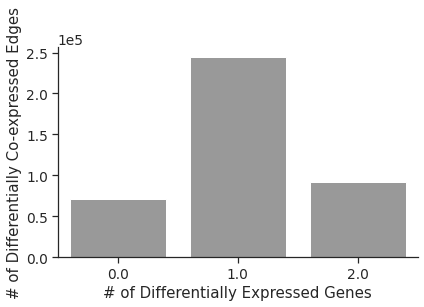

In [114]:
de_counts = dce_edges.Gene1.isin(marker_genes).astype(
    float) + dce_edges.Gene2.isin(marker_genes).astype(float)
ax = sns.countplot(de_counts, color='.6')
ax.set(xlabel='# of Differentially Expressed Genes',
       ylabel='# of Differentially Co-expressed Edges')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 3))
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/resub/diff_coexpression_de.pdf',
            transparent=True)

In [125]:
N = dce_nw.shape[0]
n = marker_genes.shape[0]

In [129]:
N

4201

In [130]:
n

709

In [131]:
de_counts.shape[0]

408102

In [132]:
(de_counts > 0).sum()

336388

In [128]:
perc_de = (de_counts > 0).sum() / de_counts.shape[0]
perc_de

0.8242743235759687

In [127]:
((2 * N * n) - ((n**2))) / (N**2)

0.30905559092860596